# RF microstrip: quarter wave stub filter

## Overview
We simulate a quarter wave stub bandstop filter in RF microstrip with nominal 3.5GHz notch. 

## Geometry

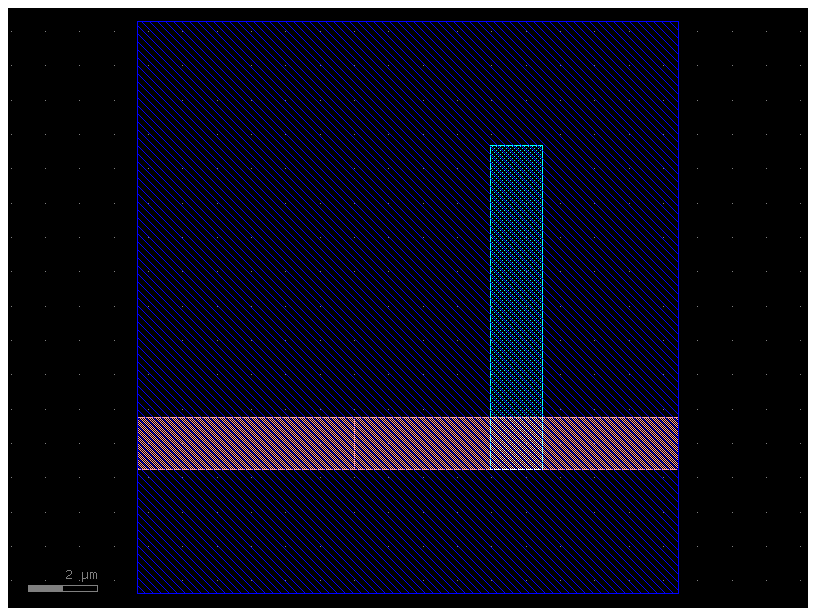

In [3]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image

path = os.path.join("runs", "stub")

# length and frequency units are arbitrary
frequency = 5  # GHz
wl1f = 300  # vacuum wavelength at 1 unit of frequency in your units
wavelength = wl1f / frequency  # characteristic wavelength
frequencies = np.linspace(3, 7, 81).tolist()
bandwidth = max(frequencies) - min(frequencies)

# microstrip
w_line = 1.52  # mm
th = 0.035  # mm
d = 0.8  # mm
c = 87.5 / 139  # relative signal speed, from microstrip calculator

wl_sig = wl1f * c / frequency  # mm
l_stub = wl_sig / 4
l_line = 1 * l_stub
lateral_port_margin = height_port_margin = 3 * d
margin = zmargin = 1.5 * lateral_port_margin
source_port_margin = 1 * (w_line + 2 * lateral_port_margin)

# layers
FEED = 1, 0
STUB = 2, 0
SUB = 10, 0

# make geometry in gdsfadory
# alternatively can import .gds into gdsfadory
c = gf.Component()
feed = c << lumi.straight(length=l_line, width=w_line, layer=FEED)
stub = c << lumi.straight(length=l_stub, width=w_line, layer=STUB)
stub.rotate(90)
stub.movex(l_line / 2)
stub.movey(-w_line / 2)
ext = c << lumi.straight(source_port_margin, width=w_line, layer=FEED)
ext.connect("o2", feed.ports["o1"])

for i in (1, 2):
    c.add_port(f"o{i}", port=feed.ports[f"o{i}"])

c << gf.components.bbox(component=c, layer=SUB, top=margin, bottom=margin)
c.plot()

## Solve

saving mode plots to runs\stub\modes\1
solving modes with PEC boundaries
Solving port modes with FEM...


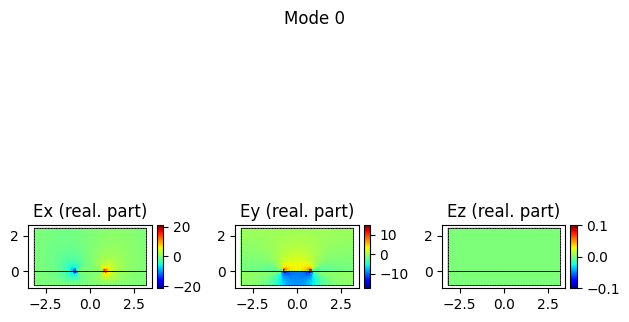

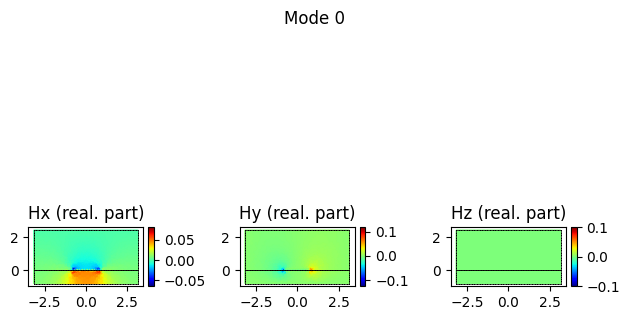

c:\Users\default.LAPTOP-HMRU58MH\anaconda3\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


[{'modes': [[{'Ex': array([[-4.18778419e-03+0.j, -7.03884931e-03+0.j, -2.79813720e-02+0.j,
        -1.94061845e-02+0.j, -3.05470396e-02+0.j, -4.42388850e-02+0.j,
        -4.41973843e-02+0.j, -7.32972346e-02+0.j, -3.48082308e-02+0.j,
        -4.67830139e-02+0.j, -4.75404746e-02+0.j, -3.58390856e-02+0.j,
        -5.38187700e-02+0.j, -3.00276827e-02+0.j, -2.88492171e-02+0.j,
        -2.62254404e-02+0.j, -5.05764540e-02+0.j, -5.80649186e-02+0.j,
        -3.41210509e-02+0.j, -4.25025209e-02+0.j],
       [-2.41529704e-02+0.j, -4.64279187e-02+0.j, -6.40840121e-02+0.j,
        -6.41799528e-02+0.j, -1.04032755e-01+0.j, -9.90724829e-02+0.j,
        -1.34475175e-01+0.j, -1.72665600e-01+0.j, -1.37398522e-01+0.j,
        -1.72170058e-01+0.j, -1.89481717e-01+0.j, -1.69953627e-01+0.j,
        -1.47354349e-01+0.j, -1.28684478e-01+0.j, -1.17531951e-01+0.j,
        -1.06980191e-01+0.j, -1.08023219e-01+0.j, -1.33357653e-01+0.j,
        -1.26744659e-01+0.j, -1.26171523e-01+0.j],
       [-3.32337498e-02+0.

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'runs\\stub\\frames'

In [4]:
# adaptive meshing
nres = 16
dx0 = wavelength / nres

layer_stack = LayerStack(
    layers={
        "feed": LayerLevel(
            layer=LogicalLayer(layer=FEED),
            zmin=d,
            thickness=th,
            material="PEC_feed",
            mesh_order=10,
        ),
        "stub": LayerLevel(
            layer=LogicalLayer(layer=STUB),
            zmin=d,
            thickness=th,
            material="PEC_stub",
            mesh_order=20,
        ),
        "core": LayerLevel(
            layer=LogicalLayer(layer=SUB),
            zmin=0.0,
            thickness=d,
            material="substrate",
            mesh_order=30,
        ),
    }
)

# materials
eps_substrate = 4.3
n_substrate = np.sqrt(eps_substrate) 

dx = w_line / 4 # 4 mesh points across the strip
n_line = dx0 / (dx) # mesh density relative to vacuum  

materials_library = {
    'substrate': lumi.Material(epsilon=eps_substrate),
    'PEC_feed': lumi.PECMaterial(mesh_density=n_line),
    'PEC_stub': lumi.PECMaterial(mesh_density=n_line),
}
materials_library["background"] = lumi.Material(epsilon=1.0)

modes = [
    lumi.Mode(
        frequencies=[frequency],
        metallic_boundaries=["-y", "feed"],
        nmodes=1,
        start=[-(w_line/2+lateral_port_margin),-d],
        stop=[(w_line/2+lateral_port_margin),th+height_port_margin],
        voltage_line=[(0,0),(0,d)],
        current_loop=[(-w_line/2-dx, d-dx),(-w_line/2-dx, d+th+dx),(w_line/2+dx, d+th+dx),(w_line/2+dx, d-dx)],
    )
]

sources = [
    lumi.Source(
        "o1", frequency=frequency, duration=.5, source_port_margin=source_port_margin
    )
]

lumi.make(    
    path=path,
    component=c,
    frequency=frequency,
    frequencies=frequencies,
    wl1f=wl1f,
    boundaries=["PML", "PML", ["PEC", "PML"]],
    #
    sources=sources,
    #
    modes=modes,
    lateral_port_margin=lateral_port_margin,
    height_port_margin=[0, height_port_margin],
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    zmin=0.0,
    zmax=d + th + zmargin,
    #
    nres=nres,
    relative_courant=0.9,  # relative courant number between 0 and 1
    relative_pml_depths=[1, 0.3, 0.3],
    Tsim=20,  # max time
    field_decay_threshold=0.01,  # field decay threshold for stopping simulation
    # visualization
    views=[lumi.View('Ez',x=-source_port_margin, y=0, z=d / 2),
    lumi.View('Ez',x=-source_port_margin,y= 0, z=d + th / 2)],
    #
    saveat=0.5,  # save frame for plotting every _ periods
    gpu="CUDA",  # use GPU acceleration)
)
lumi.solve(path)
lumi.plot(path)
display(Image(os.path.join(path, "halfway.png")))

## Analysis

loading solution from c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\stub


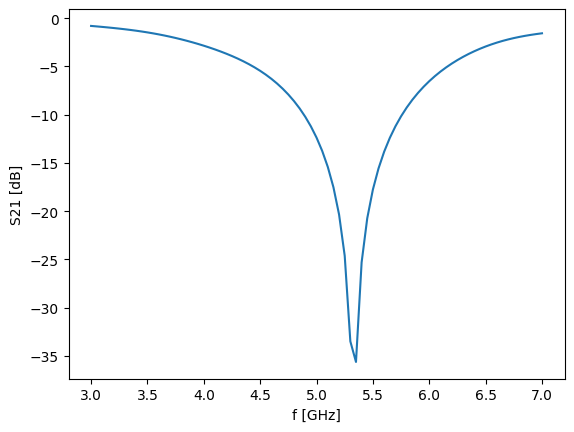

In [ ]:
import math

sol = lumi.load(path)
x = frequencies
y = lumi.query(sol, "To2@0,o1@0")
# y = lumi.query(sol, "T2,1")
y = [10 * math.log10(v) for v in y]
plt.plot(x, y)
plt.xlabel("f [GHz]")
plt.ylabel("S21 [dB]")
plt.show()